In [412]:
import pandas as pd
import re
import numpy as np

def time_in_seconds(df):
    t = df.t.apply(lambda t_string : np.int8(np.array(re.split('\W', t_string))))
    seconds = lambda array : array[0]*60 + array[1] + array[2]/100
    df['t'] = t.apply(seconds)
    return df

def zero_start(df):
    t0 = df['t'][0]
    df['t'] = df['t'] - t0
    return df

In [413]:
from scipy.stats import t
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr
from sympy import latex
from sympy import Symbol, latex, diff, sympify, simplify
from sympy.core.numbers import Float, Integer

class LinModel():
    def __init__(self, dataframe, xlabel='x', ylabel='y', label='', x_units='', y_units='', round_figures=3, rename_x='', x0_form=False):
        self.model_label = label 
        self.x_units = x_units
        self.y_units = y_units
        self.x_var = dataframe[xlabel].copy()
        self.y_var = dataframe[ylabel].copy()
        
        self.fit()
        
        self.pars = self.vars_stat_summary[['Parámetro', 'Valor estimado']].set_index('Parámetro')
        
        if x0_form == True:
            b = self.pars.loc['b']
            m = self.pars.loc['m']
            x0 = - b/m 
            sign = '+' if x0['Valor estimado'] < 0 else '-'

            self.pars.loc[xlabel + '0'] = x0
            self.rhs = sympify('m *(' + xlabel + sign + xlabel + '0)')  if rename_x == '' else sympify('m *(' + rename_x + sign + xlabel + '0)')
            rhs = str(self.rhs)
            format_string = "{:." + str(round_figures) + "f}"
            rhs = rhs.replace('m', str(format_string.format(m['Valor estimado'])))
            rhs = rhs.replace(xlabel + '0', str(format_string.format(np.abs(x0['Valor estimado']))))
            self.rhs_subs = sympify(rhs, evaluate=False)
        else: 
            self.rhs = sympify('m *' + xlabel + ' + b') if rename_x == '' else sympify('m *' + rename_x + ' + b')
            self.rhs_subs = self.rhs.subs(self.pars.transpose().round(round_figures).items())
         
        self.lhs = sympify(ylabel + '(' + xlabel + ')')   
        self.expression = str(self.lhs) + ' = ' + str(self.rhs_subs)
        self.ln_expression = latex(self.lhs) + ' = ' + latex(self.rhs_subs)
        

    def fit(self):
        def stat_error(std, dof):
            t_95 = t.isf(0.025, dof)
            return std*t_95

        coefficients, covariance_matrix = np.polyfit(self.x_var, self.y_var, 1, cov=True)
        self.slope, self.intercept = coefficients
        
        dof = len(self.x_var)-2 # degrees of freedom
        std_slope, std_intercept = np.abs(np.sqrt(np.diag(covariance_matrix)))
        unc_slope, unc_intercept = (stat_error(std_slope, dof), stat_error(std_intercept, dof))
        cov = covariance_matrix[0,1]
        
        x_min = self.x_var.min()
        x_max = self.x_var.max()
        #interval_length = x_max - x_min
        prediction_func = lambda x: self.slope*x + self.intercept
        
        y_predicted = prediction_func(self.x_var) # f_i = f(x_i)
        ss_res = np.sum((self.y_var - y_predicted)**2)
        ss_tot = np.sum((self.y_var - self.y_var.mean())**2)
                
        pearson_correlation = cov/std_intercept/std_slope
        coef_of_determination = 1 - ss_res/ss_tot
        
        # Falta añadir el error experimental, solo se reporta el estadístico!
        
        self.fit_summary = pd.Series(
            data={
                'Pearson correlation r': pearson_correlation,
                'Coefficient of determination R^2': coef_of_determination
            })

        self.vars_stat_summary = pd.DataFrame(
            data={
                'Parámetro' : ['m', 'b'], 
                'Valor estimado':[self.slope, self.intercept],
                'Error estándar': [std_slope, std_intercept], 
                'Incertidumbre':[unc_slope, unc_intercept]
            })
        
    def f_model(self, x):
        return self.slope*x + self.intercept
    
    def plot(self, ax=None, xlabel='', ylabel='', color = (0,0,0.8), legend=True, show_expression=True, data_label=''):
        label = self.model_label
        if type(ax) == type(None):
            _, ax = plt.subplots(1,1)
            
        x = self.x_var
        y = self.y_var

        x_min = x.min()
        x_max = x.max()
        
        x_grid = np.linspace(x_min, x_max, 100)
        y_model = self.f_model(x_grid)
        
        if xlabel == '':
            xlabel += x.name
        if ylabel == '':
            ylabel += y.name
        #curve_label = '$' + str(ylabel) + ' = ' +str(self.rhs_subs) + '$' if show_expression is True else ''
        curve_label = '$' + self.ln_expression + '$'
        
        if self.x_units != '':
            xlabel +=  ' (' + self.x_units + ')'
        if self.y_units != '':
            ylabel += ' (' + self.y_units + ')'
                
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        ax.errorbar(x=x, y=y, marker = '.', ls='', ms='5', color = color, label=data_label)
        ax.plot(x_grid, y_model, color=(*color, 0.3), ls='-', label=curve_label)
        if legend is True:
            ax.legend()

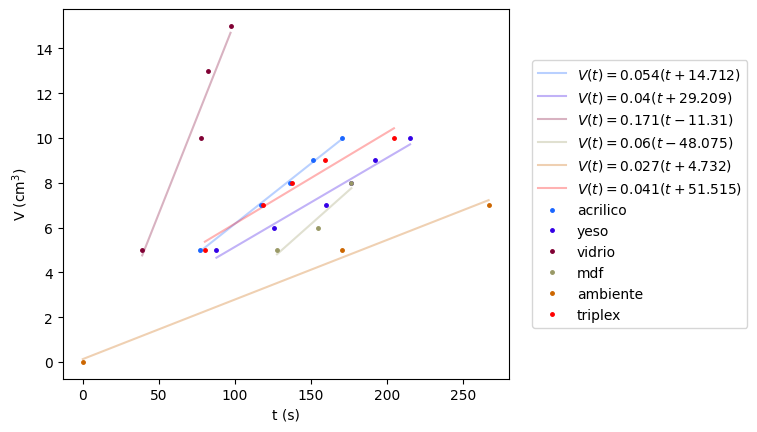

In [414]:
materials_names = ['acrilico', 'yeso', 'vidrio', 'mdf', 'ambiente', 'triplex']
tablas_de_datos = {material_name : pd.read_csv('datos/' + material_name + '.csv') for material_name in materials_names}

for name, table in tablas_de_datos.items():
    table = time_in_seconds (table)
    #table = zero_start(table)

linear_models = [LinModel(tablas_de_datos[name], xlabel='t', ylabel='V', y_units='cm$^3$', x_units='s', x0_form=True, label=name, round_figures=3) for name in materials_names]

fig, ax = plt.subplots(1,1)
colors = np.random.randint(1, 5, size=(3, 4))
pos = ax.get_position()

#colors = np.random.random_sample([len(materials_names),3])
colors = [
    [0.1,0.4,1],
    [0.2, 0, 0.9],
    [0.5, 0, 0.2],
    [0.6, 0.6, 0.4],
    [0.8, 0.4, 0],
    [1,0,0]
]
for model, color  in zip(linear_models, colors):
    model.plot(ax=ax, color=color, data_label=model.model_label)

ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.55, 0.5))
plt.savefig('report/img/V_vs_t.png', dpi=300, bbox_inches='tight')

In [415]:
materials = pd.DataFrame(columns=['V_dot', 'R^2'])
for model in linear_models:
    materials.loc[model.model_label] = [model.vars_stat_summary.iloc[0]['Valor estimado'], model.fit_summary['Coefficient of determination R^2']]
materials['V_dot'] = (materials.V_dot - materials.V_dot.loc['ambiente'])
materials.drop(('ambiente'), inplace=True)
materials.columns
materials

,V_dot,R^2
acrilico,0.027144,0.997376
yeso,0.013143,0.967561
vidrio,0.144530,0.948731
mdf,0.033734,0.938020
triplex,0.014132,0.959368


In [416]:
def A(D0,Df):
    # area in centimeters
    return np.pi/16*(D0 + Df)**2
materials['A'] = [
    A(6.12,6.04),
    A(6.24,6.12),
    A(5.74, 5.45),
    A(6.04, 5.84),
    A(5.84,5.74)]
rho_agua = 1 # grams per cubic centimeter
materials['h'] = [0.54, 0.52, 0.54, 0.49, 0.55] # centimeters
Lf = 79.71# calories_4°C per gram
Delta_T = 100 # (100 - 0) °C

Q = rho_agua*materials.V_dot*Lf
y = materials.h/materials.A
TT = 1/Delta_T
error = np.vectorize(lambda reference_value, measured_value : np.abs(reference_value - measured_value)/measured_value*100)
conversion_factor = 419 # calories_4C per s/cm/K to W/m/K
materials['kappa'] = Q*y*TT*conversion_factor
materials['kappa_reference'] = [0.19, 0.43, 0.86, 0.08, 0.11]
materials['e%'] = np.abs(materials.kappa.round(2) - materials.kappa_reference.round(2))/materials.kappa_reference.round(2)*100
materials[['kappa', 'kappa_reference','e%']].sort_values(by=['e%'])


,kappa,kappa_reference,e%
triplex,0.098590,0.11,9.090909
acrilico,0.168613,0.19,10.526316
vidrio,1.060201,0.86,23.255814
yeso,0.076098,0.43,81.395349
mdf,0.199215,0.08,150.000000


In [417]:
def style(df):
    df_ = df.copy()
    s = df_.style
    #s.hide(axis='index')
    s.format(precision=2, subset=['kappa', 'kappa_reference'], na_rep='')
    s.format(precision=1, subset=['e%'])
    return s

a = style(materials[['kappa', 'kappa_reference','e%']].sort_values(by=['e%']))
a = a.to_latex(hrules=True, siunitx=True)
print(a)


\begin{tabular}{lSSS}
\toprule
{} & {kappa} & {kappa_reference} & {e%} \\
\midrule
triplex & 0.10 & 0.11 & 9.1 \\
acrilico & 0.17 & 0.19 & 10.5 \\
vidrio & 1.06 & 0.86 & 23.3 \\
yeso & 0.08 & 0.43 & 81.4 \\
mdf & 0.20 & 0.08 & 150.0 \\
\bottomrule
\end{tabular}



In [418]:
b = materials[['V_dot', 'R^2']].style
b.format(precision=3)
print(b.to_latex(hrules=True, siunitx=True))

\begin{tabular}{lSS}
\toprule
{} & {V_dot} & {R^2} \\
\midrule
acrilico & 0.027 & 0.997 \\
yeso & 0.013 & 0.968 \\
vidrio & 0.145 & 0.949 \\
mdf & 0.034 & 0.938 \\
triplex & 0.014 & 0.959 \\
\bottomrule
\end{tabular}



## Marco teórico
El calor requerido para la fusión del hielo está dado por la relación $\Delta Q = \Delta m L_{\text{fusión}}$, donde $\Delta m$ es la masa de hielo que se funde y $L_i$ es el calor latente. La ley de Fourier, para una muestra de geometría rectangular, calcula la tasa a la que el calor transita por un material dada una diferencia de temperatura entre dos caras opuestas de la muestra

$$
\begin{equation}
\frac{\Delta Q}{\Delta t} = \frac{\kappa A \Delta T}{h}
\end{equation}
$$

Juntando la relación del calor necesario para derretir el hielo y la forma como transita el calor através del material, se obtiene una relación para la constante de proporcionalidad $\kappa$ en función de la geometría e la muestra, la tasa a la que se derrite el hielo, y la diferencia de temperatura aplicada,

$$
\begin{equation}
\kappa = \rho_{\text{agua}}\dot V L_{\text {fusión}}\frac{h}{A}\frac{1}{\Delta T}
\end{equation}
$$

Donde $\dot V = \frac{\Delta V}{\Delta t} $, $L_{\text {fusión}} = 79.712$
## Conclusiones
Con un error tan grande, solo es posible descartar las mediciones para el MDF y el yeso.
